In [187]:
### Load necessary libraries ###
import glob
import os

import librosa
import librosa.display

import numpy as np
from numpy import size

import matplotlib.pyplot as plt
from matplotlib.pyplot import text

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

import tensorflow as tf
from tensorflow import keras

from IPython.display import Audio

# Global Configuration variables

In [204]:
# Debug and test variables
# Do not process all the sound in the dataset (for faster execution during script development)
REDUCED_MODE = 0
# Number of dataset sounds per folder to process in the reduced-mode.
REDUCED_MODE_SOUNDNUM = 150

# sound processing variables
SOUND_SR = 44100  # sound sampling in Hertz
SOUND_F_FFT = 2048  # Samples per FFT window
SOUND_HOP_LEN = 512 # Hop Length
SOUND_N_MELS = 25 # Number of mel frequencies to analyze

SOUNDSEG_SIZE = 41  # windows per subsound / segment
SOUNDSEG_OVERLAP = 0.4  # 40% overlapping factor for engine sounds

SOUNDSEG_OVERSAMPLING = 4  # how many times to increase the engine category samples
SOUNDSEG_CLASS2OVERSAMPLE = 5  # Oversample the engine class (num. 5)

# Preprocessing
PREPROC_SKIP = 0  # Skip preprocessing files and use previosuly saved '.npz'

# Paths and folders
soundsPath = 'UrbanSounds8K/1_audioFiles/'
soundsSubPaths = np.array(['fold1', 'fold2', 'fold3', 'fold4',
                          'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10'])
processedPath = "UrbanSounds8K/2_featuresProcessed/"
trainingResultsPath = "UrbanSounds8K/3_trainingResults/"
confusionFile = "confusion_matrix"
trainingFile = "trainingResults"
logPath = "UrbanSounds8k/4_processingLog"


# Methods for preprocessing and feature extraction

In [189]:
# Divide an sound file into shorter and overlapped parts.
def soundSegmentation(soundSignal, subsoundSize, overlapFactor=SOUNDSEG_OVERLAP):
    start = 0
    while start < len(soundSignal):
        yield int(start), int(start + subsoundSize)
        start += (subsoundSize // (1/(1-overlapFactor)))

# Add white noise to signal respecting a maximum amplitude based on RMS energy of the original signal
def soundAddGaussianNoise(soundSignal, sampleRate = SOUND_SR, maxAmplitude_percRMS = 0.1):
    signalRMS = (np.average(soundSignal**2))**(1/2);
    
    randomFact1 = np.random.rand(1);
    randomFact2 = np.random.rand(1);

    factMax =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 > randomFact2 else randomFact2);
    factMin =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 < randomFact2 else randomFact2);

    transform = AddGaussianNoise(min_amplitude=factMin, max_amplitude=factMax,p=1);
    augSoundSignal = transform(soundSignal,sample_rate=44100);

    return augSoundSignal

# Load sound with Librosa and make it faster or slower (time stretching)
def soundLoadAndStretch(soundPath, sampleRate = SOUND_SR, maxStretch = 0.1):
    randomFact = (np.random.rand(1) - 0.5) * maxStretch;
    soundSignal, sr = librosa.load(soundPath, sr=SOUND_SR * (1+maxStretch));
    return soundSignal;


In [190]:
# Extract features from sound files, generating spectogram segments (images)
def extractSoundFeature(soundsPath, soundsSubPath, n_mels=SOUND_N_MELS, n_windows=SOUNDSEG_SIZE, hopLength=SOUND_HOP_LEN,
                        soundOversamplingFact=SOUNDSEG_OVERSAMPLING, soundOverClass=SOUNDSEG_CLASS2OVERSAMPLE):

    subsoundSize = hopLength * (n_windows - 1)
    features_AM, origClasses_A, segSounds_AA = [], [], []

    # Map all sound samples paths inside the folder
    allsoundsPath_A = glob.glob(os.path.join(
        soundsPath, soundsSubPath, "*.wav"))

    # Iterate and extract features from each sound
    idxsound, idxSegment = 0, 0
    for soundPath in allsoundsPath_A:
        idxsound = idxsound+1
        # Early stop for reduced mode
        if REDUCED_MODE == 1 and idxsound == REDUCED_MODE_SOUNDNUM:
            break

        # Extract sound class by parsing file name
        soundClass = int(soundPath.split('/')[2].split('-')[1])

        # Loop more than once in the same sound (oversampling) if is engine class (5)
        if soundClass == soundOverClass:
            maxRepeatOverSampl = soundOversamplingFact  # Oversampling by repetition
            overlapFactor = SOUNDSEG_OVERLAP  # Oversampling by overlapping
        else:
            maxRepeatOverSampl = 1
            overlapFactor = 0

        idxOverSampl = 0
        for idxOverSampl in np.arange(maxRepeatOverSampl):

            # Extract '.wav' sound to an 1-D array and apply stretching if required
            if idxOverSampl > 0:
                soungSignal_A = soundLoadAndStretch(
                    soundPath, SOUND_SR, 0.1)  # stretch
            else:
                soungSignal_A = soundLoadAndStretch(
                    soundPath, SOUND_SR, 0.0)  # don't stretch

            # Create subsegments from sound file and extract the features
            segSoundSignal_AA, segSoundSpect_AM, segSoundClass_A = [], [], []  # Init arrays
            for (start, end) in soundSegmentation(soungSignal_A, subsoundSize, overlapFactor):
                if (len(soungSignal_A[start:end]) == subsoundSize):
                    idxSegment = idxSegment+1

                    # Append sound class to segments class array
                    segSoundClass_A.append(soundClass)

                    # Extract segment from sound data - 1D Array
                    segSoundSignal_A = soungSignal_A[start:end]
                    segSoundSignal_AA.append(segSoundSignal_A)  # All segs. array

                    # Apply data augmentation if repeated loop
                    if idxOverSampl > 0:
                        segSoundSignal_A = soundAddGaussianNoise(segSoundSignal_A, SOUND_SR, 0.1)

                    # Transform to spectogram in decibels - 2D Matrix
                    segsoundSpect_M = librosa.feature.mfcc(y=segSoundSignal_A, n_mfcc=n_mels)
                    #segsoundSpect_M = librosa.feature.melspectrogram(y=segSoundSignal_A, n_mels=n_mels)
                    #segsoundSpect_M = librosa.amplitude_to_db(segsoundSpect_M)

                    # Reshape and append to preprocessed spectograms
                    segsoundSpect_M = segsoundSpect_M.T.flatten()[:, np.newaxis].T
                    segSoundSpect_AM.append(segsoundSpect_M)

            segSoundSpect_AM = np.asarray(segSoundSpect_AM).reshape(len(segSoundSpect_AM), n_mels, n_windows, 1)

            # If last sound not empty, stack together with others
            if len(segSoundSpect_AM) > 0:
                segSounds_AA.append(segSoundSignal_AA)
                features_AM.append(segSoundSpect_AM)
                origClasses_A.append(segSoundClass_A)

    print('Num of segments for this folder - ', idxSegment, ' - out of - ', idxsound, ' sounds.')

    # Stack all data 'per segment' and not 'per sound'
    segSounds_AA = np.concatenate(segSounds_AA, axis=0)
    features_AM = np.concatenate(features_AM, axis=0)
    origClasses_A = np.concatenate(origClasses_A, axis=0)

    # Convert UrbanSounds8K class to binary 'is/isn't engine'
    engineClasses_A = np.array(
        list(map(lambda x: 1 if x == 5 else 0, origClasses_A)))

    return segSounds_AA, features_AM, engineClasses_A


# CNN Model Definition 

In [191]:
### Define convolutional network architecture ###
def CNN_modelDefinition(useLeakyRelu=0):
    keras.backend.clear_session()

    pool_size = (2, 2)
    kernel_size = (3, 3)
    input_shape = (SOUND_N_MELS, SOUNDSEG_SIZE, 1)
    num_classes = 2  # 10

    # ---------- Convolutional + Pooling Layer 1 ---------- #
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(80, kernel_size, padding="same",
              input_shape=input_shape, dilation_rate=1))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Convolutional + Pooling Layer 2 ---------- #
    model.add(keras.layers.Conv2D(80, kernel_size,
              padding="same", dilation_rate=2))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Pooling Layer Layer ---------- #
    model.add(keras.layers.GlobalMaxPooling2D())

    # ---------- Flat Layers ---------- #
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy", "mse"])
    return model


# Sound Processing and Features Extraction

Num of segments for this folder -  11065  - out of -  873  sounds.
Num of segments for this folder -  11217  - out of -  888  sounds.
Num of segments for this folder -  11965  - out of -  925  sounds.
Num of segments for this folder -  12293  - out of -  990  sounds.
Num of segments for this folder -  11779  - out of -  936  sounds.
Num of segments for this folder -  11241  - out of -  823  sounds.
Num of segments for this folder -  11337  - out of -  838  sounds.
Num of segments for this folder -  9878  - out of -  806  sounds.
Num of segments for this folder -  10373  - out of -  816  sounds.
Num of segments for this folder -  10615  - out of -  837  sounds.


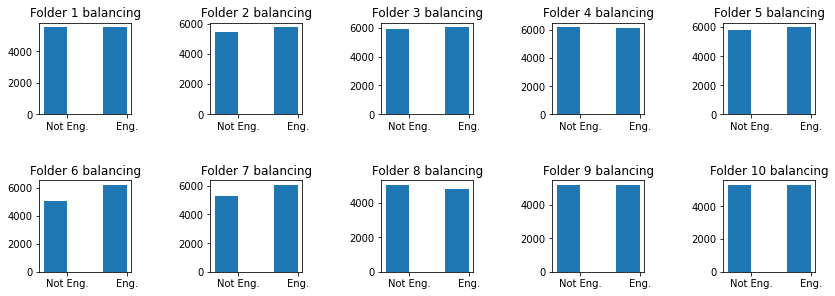

In [192]:
# Pre-process and extract feature from the data
if PREPROC_SKIP == 0:
    fig, axes = plt.subplots(2, 5)
    axes = axes.ravel()
    fig.set_figheight(10*0.5)
    fig.set_figwidth(25*0.5)
    fig.tight_layout(pad=4.5)

    # Loop through all sound folders
    idxFold = 0
    for soundSubPath in soundsSubPaths:
        # Extract files from folder and save externally for reuse
        segSounds_AA, features_AM, classes_A = extractSoundFeature(soundsPath, soundSubPath)
        np.savez("{0}{1}".format(processedPath, soundSubPath),
                 segSounds = segSounds_AA, features=features_AM, classes=classes_A)

        # Plot histogram of data balancing per folder
        axes[idxFold].set_title('Folder ' + str(idxFold+1) + ' balancing')
        tmpData = np.asarray(classes_A)
        tmpData = [np.count_nonzero(tmpData == 0),
                   np.count_nonzero(tmpData == 1)]
        axes[idxFold].bar(['Not Eng.', 'Eng.'], tmpData,
                          align='edge', width=-0.4, label="Train")

        idxFold += 1


# CNN Training and Testing

In [193]:
### Train and evaluate via 10-soundsSubPaths cross-validation ###
kf = KFold(n_splits=10)

# List containing all confusion matrix for all K-Fold Train-Test
allConfusionMatrix_AM = []
# Array containing the results of the training for each train/test set.
allFitResults_A = []

# Loop to traint-test in all folder combinations.
idx = 0
for train_index, test_index in kf.split(soundsSubPaths):
    idx = idx+1

    print('--> Starting a loop! - Folder ', idx)

    x_train, y_train = [], []

    # ---------------- STEP 1 ----------------
    # Load training data from 9 out of 10 folders
    # Loop through all training folders and gather data in single feature array
    for idxTrainFolder in train_index:
        print('-> Getting data from TRAINING folder ', idxTrainFolder+1)
        # Read pre-saved features or segments of an sound file (pre-processed)
        train_data = np.load("{0}/{1}.npz".format(processedPath,
                             soundsSubPaths[idxTrainFolder]), allow_pickle=True)

        # Append all the 'features' and 'classes' train datasets
        # in a single list containing all train folders data
        x_train.append(train_data["features"])
        y_train.append(train_data["classes"])

    # Stack all the folders in a single X/Y dataset
    x_train = np.concatenate(x_train, axis=0).astype(np.float32)
    y_train = np.concatenate(y_train, axis=0).astype(np.float32)
    print('-> TRAIN dataset size: ', len(x_train))

    # ---------------- STEP 2 ----------------
    # Load test data from 1 out of 10 folders
    # Load test data from the test folder
    print('\n-> Getting data from TESTING folder ', test_index+1)
    test_data = np.load("{0}/{1}.npz".format(processedPath,
                        soundsSubPaths[test_index][0]), allow_pickle=True)
    x_test = test_data["features"]
    y_test = test_data["classes"]
    print('-> TEST dataset size: ', len(x_test))

    CNN_model = CNN_modelDefinition(useLeakyRelu=1)

    print('\n--> Fitting model!')
    allFitResults_A.append(CNN_model.fit(x_train, y_train, validation_data=(
        x_test, y_test), epochs=12, batch_size=32, verbose=1))

    # Predict results from test data
    y_test_pred = []
    y_test_pred = CNN_model.predict(x_test)  # Categorical results
    y_test_pred = np.asarray(tf.argmax(y_test_pred, axis=1))  # OHE to Category

    # Append the confusion matrix of this K-Fold run to a matirx list
    allConfusionMatrix_AM.append(confusion_matrix(
        y_test, y_test_pred, normalize='true'))

    # Early stop for reduced mode
    if REDUCED_MODE == 1:
        break

# Save the resulting confusion matrices and training data
np.savez("{0}{1}".format(trainingResultsPath, confusionFile),
         allConfusionMatrix_AM=allConfusionMatrix_AM);

np.savez("{0}{1}".format(trainingResultsPath, trainingFile),
         allFitResults_A=allFitResults_A);


--> Starting a loop! - Folder  1
-> Getting data from TRAINING folder  2
-> Getting data from TRAINING folder  3
-> Getting data from TRAINING folder  4
-> Getting data from TRAINING folder  5
-> Getting data from TRAINING folder  6
-> Getting data from TRAINING folder  7
-> Getting data from TRAINING folder  8
-> Getting data from TRAINING folder  9
-> Getting data from TRAINING folder  10
-> TRAIN dataset size:  100698

-> Getting data from TESTING folder  [1]
-> TEST dataset size:  11065

--> Fitting model!
Epoch 1/12
3147/3147 [==============================] - 218s 69ms/step - loss: 0.3573 - accuracy: 0.8410 - mse: 0.3849 - val_loss: 0.7593 - val_accuracy: 0.6239 - val_mse: 0.3821
Epoch 2/12
3147/3147 [==============================] - 217s 69ms/step - loss: 0.2860 - accuracy: 0.8736 - mse: 0.4099 - val_loss: 0.7516 - val_accuracy: 0.7419 - val_mse: 0.4028
Epoch 3/12
3147/3147 [==============================] - 218s 69ms/step - loss: 0.2466 - accuracy: 0.8940 - mse: 0.4212 - val_l

Class identifiers according to UrbanSounds 8k :

0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

# Plot all the confusion matrix + final average

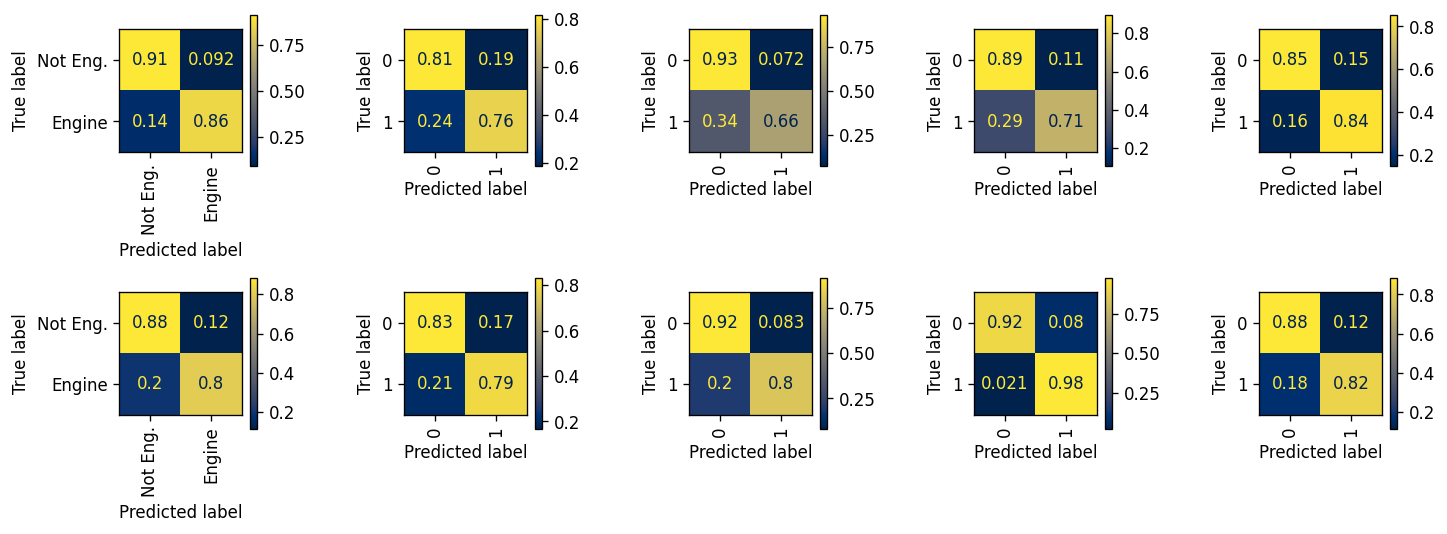

In [207]:
# Load from pre-saved file
allConfusionMatrix_AM = np.load(
    "{0}/{1}.npz".format(trainingResultsPath, confusionFile), allow_pickle=True)["allConfusionMatrix_AM"]

# Plot all confusion matrix
f, a = plt.subplots(2, 5, dpi=120)
f.set_figheight(10*.5)
f.set_figwidth(25*.5)
f.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for cm in allConfusionMatrix_AM:
    if idxCol == 0:
        cmDisplay = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=['Not Eng.', 'Engine'])
    else:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)

    cmPlt = cmDisplay.plot(ax=a[idxRow][idxCol],
                           cmap='cividis', xticks_rotation='vertical')

    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1

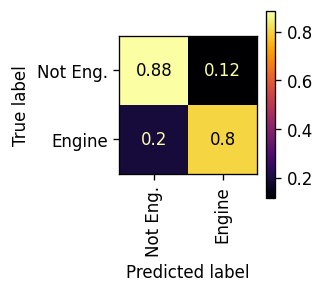

In [195]:
# Average results
confusionMatrixAvg_M = np.zeros([2,2]);
for cm in allConfusionMatrix_AM:
    confusionMatrixAvg_M += cm;
confusionMatrixAvg_M *=0.1;

# Plot
f, a = plt.subplots(dpi=120)
f.set_figheight(2)
f.set_figwidth(2)
f.tight_layout(pad=0.5)

cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixAvg_M, display_labels=['Not Eng.', 'Engine'])
cmDisplay.plot(ax=a,  cmap='inferno', xticks_rotation='vertical')

# Sound segment analysis

In [197]:
# Find a non-engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 0:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!


In [198]:
# Find an engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 1:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!


# Plot categories distribution

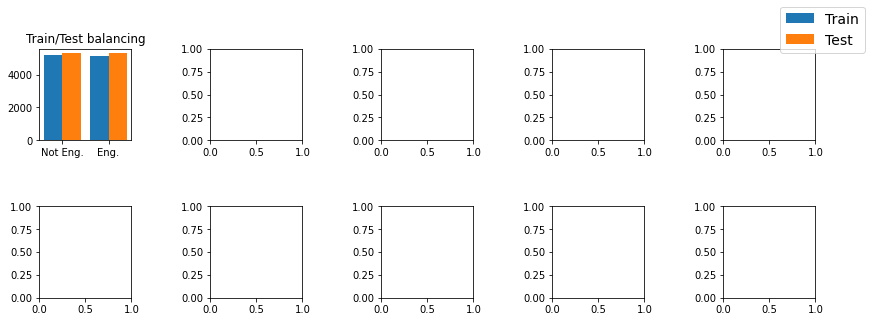

In [196]:
f, a = plt.subplots(2, 5)
a = a.ravel()

f.set_figheight(10*0.5)
f.set_figwidth(25*0.5)
f.tight_layout(pad=4.5)

a[0].set_title('Train/Test balancing')

# Histogram of data per class in train dataset
tmpData = np.asarray(train_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData,
         align='edge', width=-0.4, label="Train")

# Histogram of data per class in test dataset
tmpData = np.asarray(test_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData, align='edge', width=0.4, label="Test")

f.legend(fontsize=14)
